In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing 

1/ Import framework et data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Projet_1_initialisation_MLops/data'))
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import re
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
import random

BASE_DIR = Path(r"C:/Users/coach/Desktop/datascientest/OpenClassrooms/Projects_MLops/Projet_1_initialisation_MLops")
DATA_RAW = BASE_DIR / "data/raw"
DATA_PROC = BASE_DIR / "data" / "proceed"
#DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Projet_1_initialisation_MLops/data/proceed/homecredit_features.csv'
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Projet_1_initialisation_MLops/data/proceed/homecredit_features.csv"
#DATA_PROC / "homecredit_features.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
#print(df.head())

train_df = df[df["TARGET"].notna()]
train_autoML = train_df.drop(columns=["SK_ID_CURR"])
X = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy="median") #remplace les valeurs manquantes par la médiane de chaque colonne
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
y = train_df["TARGET"]
print(X.shape, y.shape)
print(y.value_counts(normalize=True)) #desequilibre des classes 0 (92%) et 1(8%)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['raw', 'proceed']
(356251, 276)
(307507, 274) (307507,)
TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64


In [2]:
#reduire la taille des donnees pour test rapide en conservant repartition des classes
X = X.sample(n=100000, random_state=42)
y = y.loc[X.index]
print(X.shape, y.shape)

(100000, 274) (100000,)


2/ Metriques & business optimization

In [3]:
# metrique cout metier
def business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * fn_cost + fp * fp_cost

# meilleur seuil
def find_best_threshold(y_true, y_proba):
    thresholds = np.arange(0.05, 0.95, 0.05)
    costs = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cost = business_cost(y_true, y_pred)
        costs.append(cost)
    best_idx = np.argmin(costs)
    return thresholds[best_idx], costs

business_scorer = make_scorer(business_cost, greater_is_better=False)

3/ Modeles IA

In [4]:
# cross-validation stratifiée 5-fold
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

# calcul rapport des classes pour XGBoost
neg = (y == 0).sum()
pos = (y == 1).sum()
scale_pos_weight = neg / pos

# definition des modeles ajout modele naif dummmyClassifier
models = {
    "Dummy": DummyClassifier(strategy="most_frequent",random_state=42),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "RandomForest": RandomForestClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ),
    "MLP": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            random_state=42
        ))
    ]),
    "XGBoost": xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        n_jobs=-1,
        random_state=42
    )}


3/ Training des modèles

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)



========== Dummy =========
 Fold 1


2026/02/11 21:17:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object 

 Fold 2


2026/02/11 21:19:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object 

 Fold 3


2026/02/11 21:20:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object 

 Fold 4


2026/02/11 21:22:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object 

 Fold 5


2026/02/11 21:24:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object 


========== Logistic Regression =========
 Fold 1


2026/02/11 21:27:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_Logistic_Regression' already exists. Creating a new version of this m

 Fold 2


2026/02/11 21:32:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_Logistic_Regression' already exists. Creating a new version of this m

 Fold 3


2026/02/11 21:34:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_Logistic_Regression' already exists. Creating a new version of this m

 Fold 4


2026/02/11 21:36:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_Logistic_Regression' already exists. Creating a new version of this m

 Fold 5


2026/02/11 21:39:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_Logistic_Regression' already exists. Creating a new version of this m


========== RandomForest =========
 Fold 1


2026/02/11 21:43:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_RandomForest' already exists. Creating a new version of this model...

 Fold 2


2026/02/11 21:49:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_RandomForest' already exists. Creating a new version of this model...

 Fold 3


2026/02/11 21:51:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_RandomForest' already exists. Creating a new version of this model...

 Fold 4


2026/02/11 21:54:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_RandomForest' already exists. Creating a new version of this model...

 Fold 5


2026/02/11 21:58:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_RandomForest' already exists. Creating a new version of this model...


========== MLP =========
 Fold 1


2026/02/11 22:09:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_MLP' already exists. Creating a new version of this model...
Created 

 Fold 2


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2026/02/11 22:22:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The rec

 Fold 3


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2026/02/11 22:32:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The rec

 Fold 4


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2026/02/11 22:42:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The rec

 Fold 5


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2026/02/11 22:53:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The rec


========== XGBoost =========
 Fold 1


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '31' of model 'HomeCredit_Scoring_XGBoost'.


 Fold 2


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '32' of model 'HomeCredit_Scoring_XGBoost'.


 Fold 3


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '33' of model 'HomeCredit_Scoring_XGBoost'.


 Fold 4


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '34' of model 'HomeCredit_Scoring_XGBoost'.


 Fold 5


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_XGBoost' already exists. Creating a new version of this model...
Created version '35' of model 'HomeCredit_Scoring_XGBoost'.



========== LightGBM ========
 Fold 1
[LightGBM] [Info] Number of positive: 6443, number of negative: 73557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16588
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_LightGBM' already exists. Creating a new version of this model...
Created version '26' of model 'HomeCredit_Scoring_LightGBM'.


 Fold 2
[LightGBM] [Info] Number of positive: 6443, number of negative: 73557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16592
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 249
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_LightGBM' already exists. Creating a new version of this model...
Created version '27' of model 'HomeCredit_Scoring_LightGBM'.


 Fold 3
[LightGBM] [Info] Number of positive: 6442, number of negative: 73558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16565
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_LightGBM' already exists. Creating a new version of this model...
Created version '28' of model 'HomeCredit_Scoring_LightGBM'.


 Fold 4
[LightGBM] [Info] Number of positive: 6442, number of negative: 73558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16572
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_LightGBM' already exists. Creating a new version of this model...
Created version '29' of model 'HomeCredit_Scoring_LightGBM'.


 Fold 5
[LightGBM] [Info] Number of positive: 6442, number of negative: 73558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16575
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_LightGBM' already exists. Creating a new version of this model...
Created version '30' of model 'HomeCredit_Scoring_LightGBM'.



 Résultats des modèles :

                 model  mean_auc     mean_cost  mean_threshold  mean_accuracy
1  Logistic Regression  0.750410  10757.200000           0.510        0.70289
4              XGBoost  0.738032  10973.000000           0.400        0.72675
2         RandomForest  0.723914  11361.200000           0.100        0.72282
5             LightGBM  0.751354  13100.526316           0.445        0.69490
3                  MLP  0.620851  14101.800000           0.050        0.80332
0                Dummy  0.500000  16106.000000           0.050        0.91947


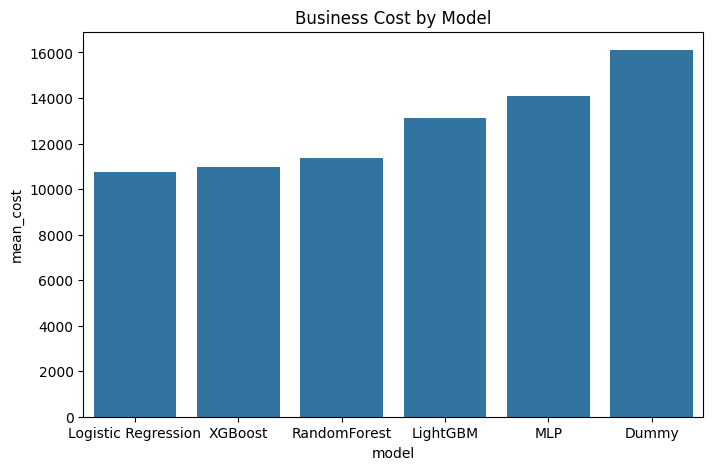

In [ ]:
# entrainement et evaluation des modeles

from logging import disable


#mlflow.set_tracking_uri("file:./mlruns") #Projet_1_initialisation_MLops/notebook/mlruns
mlflow.set_tracking_uri(
    "file:/content/drive/MyDrive/Colab Notebooks/Projet_1_initialisation_MLops/notebook/mlruns"
)
mlflow.set_experiment("HomeCredit_Scoring_all_models")
# Enable autologging for scikit-learn
mlflow.sklearn.autolog(disable==False)

results = []
for name, model in models.items():
    print(f"\n========== {name} =========")
    with mlflow.start_run(run_name=name):
        aucs = []
        costs = []
        thresholds = []
        accs = []
        for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f" Fold {fold+1}")
            X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)[:,1]
            auc = roc_auc_score(y_val, y_proba)
            best_t, _ = find_best_threshold(y_val, y_proba)
            y_pred = (y_proba >= best_t).astype(int)
            cost = business_cost(y_val, y_pred)
            acc = accuracy_score(y_val, y_pred)

            # Log metrics
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Accuracy", acc)
            mlflow.log_metric("Business_Cost", cost)
            mlflow.log_metric("Threshold", best_t)
            mlflow.set_tags({"model_type": name,"project": "HomeCredit_Scoring"})

            # Register model
            mlflow.sklearn.log_model(model,name="model",registered_model_name=f"HomeCredit_Scoring_{name.replace(' ', '_')}")

            accs.append(acc)
            aucs.append(auc)
            costs.append(cost)
            thresholds.append(best_t)

    results.append({
        "model": name,
        "mean_auc": np.mean(aucs),
        "mean_cost": np.mean(costs),
        "mean_threshold": np.mean(thresholds),
        "mean_accuracy": np.mean(accs)
    })

# model lightgbm
model_lgb = lgb.LGBMClassifier(class_weight="balanced",random_state=42,n_jobs=-1)

def clean_name(name):
    # keep letters, digits and underscore; replace others by underscore
    name = re.sub(r"[^0-9a-zA-Z_]", "_", str(name))
    # optional: collapse multiple underscores
    name = re.sub(r"_+", "_", name)
    return name
X = X.copy()
X.columns = [clean_name(c) for c in X.columns]

print(f"\n========== LightGBM ========")
with mlflow.start_run(run_name="LightGBM"):
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f" Fold {fold+1}")
        X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        model_lgb.fit(X_train, y_train)
        y_proba = model_lgb.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_proba)
        best_t, costs = find_best_threshold(y_val, y_proba)
        y_pred = (y_proba >= best_t).astype(int)
        cost = business_cost(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)
        # Log metrics
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business_Cost", cost)
        mlflow.log_metric("Threshold", best_t)
        mlflow.set_tags({"model_type": "LightGBM","project": "HomeCredit_Scoring"})

        # Register model
        mlflow.sklearn.log_model(model_lgb,name="model",registered_model_name=f"HomeCredit_Scoring_LightGBM")

        accs.append(acc)
        aucs.append(auc)
        costs.append(cost)
        thresholds.append(best_t)


results.append({
        "model": "LightGBM",
        "mean_auc": np.mean(aucs),
        "mean_cost": np.mean(costs),
        "mean_threshold": np.mean(thresholds),
        "mean_accuracy": np.mean(acc)
        })

#stockage des résultats dans un DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values("mean_cost", inplace=True)
print("\n Résultats des modèles :\n")
print(results_df.sort_values("mean_cost"))

#visualisation des résultats
plt.figure(figsize=(8,5))
sns.barplot(data=results_df,x="model",y="mean_cost")
plt.title("Business Cost by Model")
plt.show()

4/ fine tuning avec GridsearchCV

In [5]:
models = {
"Dummy": {
    "model":DummyClassifier(strategy="most_frequent",random_state=42),
    "params":{"strategy":['prior','stratified','uniform','constant']}},
"Logistic Regression": {
    "model": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=3000,
            class_weight="balanced"
        ))
    ]),
    "params": {
        "clf__C": [0.01, 0.1, 1],
        "clf__solver": ["lbfgs","liblinear"]
    }
},
"RandomForest": {
    "model": RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "params": {
        "n_estimators": [200, 400],
        "max_depth": [None, 10],
        "min_samples_leaf": [1, 5]
    }
},
"MLP": {
    "model": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            max_iter=500,
            random_state=42
        ))
    ]),
    "params": {
        "clf__hidden_layer_sizes": [(100,), (100,50)],
        "clf__alpha": [0.0001, 0.001],
        "clf__activation": ["Relu","tanh","logistic"]
    }
},
"XGBoost": {
    "model": xgb.XGBClassifier(
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ),
    "params": {
        "n_estimators": [200, 400],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1]
    }
},
"LightGBM": {
    "model": lgb.LGBMClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "params": {
        "n_estimators": [200, 400],
        "num_leaves": [31, 64],
        "learning_rate": [0.05, 0.1]
    }
}}


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)



========== Dummy ========
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/dummy.py", line 215, in fit
    raise ValueError(
ValueError: Constant tar

Best params: {'strategy': 'prior'}
Best score: -12884.0
Best threshold: 0.1
Business cost: 16110

========== Logistic Regression ========
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_gridsearch_Logistic_Regression' already exists. Creating a new version of this model...
Created version '5' of model 'HomeCredit_Scoring_gridsearch_Logistic_Regression'.


Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}
Best score: -8784.2
Best threshold: 0.55
Business cost: 10412

========== RandomForest ========
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_gridsearch_RandomForest' already exists. Creating a new version of this model...
Created version '14' of model 'HomeCredit_Scoring_gridsearch_RandomForest'.


Best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}
Best score: -9190.8
Best threshold: 0.45
Business cost: 10749

========== MLP ========
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Best params: {'clf__activation': 'logistic', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}
Best score: -11879.4
Best threshold: 0.05
Business cost: 14391

========== XGBoost ========
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_gridsearch_XGBoost' already exists. Creating a new version of this model...
Created version '14' of model 'HomeCredit_Scoring_gridsearch_XGBoost'.


Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}
Best score: -12450.4
Best threshold: 0.1
Business cost: 10552

========== LightGBM ========
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 6442, number of negative: 73558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16580
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 252
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_gridsearch_LightGBM' already exists. Creating a new version of this model...
Created version '13' of model 'HomeCredit_Scoring_gridsearch_LightGBM'.


Best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}
Best score: -8407.6
Best threshold: 0.5
Business cost: 10211
                 model  mean_auc  mean_cost  mean_threshold  mean_accuracy
5             LightGBM  0.776897    10211.0            0.50        0.73875
1  Logistic Regression  0.762178    10412.0            0.55        0.74535
4              XGBoost  0.769970    10552.0            0.10        0.78560
2         RandomForest  0.745412    10749.0            0.45        0.69160
3                  MLP  0.627898    14391.0            0.05        0.84385
0                Dummy  0.500000    16110.0            0.10        0.91945


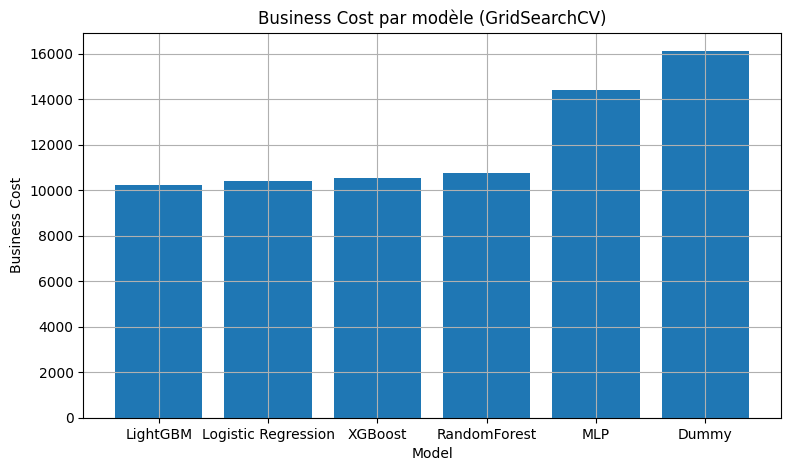

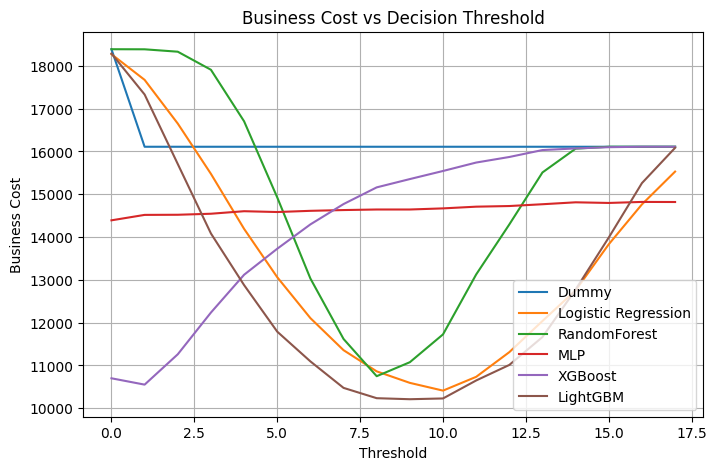

AUC: 0.7768970256184042
Accuracy: 0.73875
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     18389
         1.0       0.18      0.66      0.29      1611

    accuracy                           0.74     20000
   macro avg       0.57      0.70      0.56     20000
weighted avg       0.90      0.74      0.80     20000

Best model: LightGBM


/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'HomeCredit_Scoring_final_LightGBM' already exists. Creating a new version of this model...
Created version '5' of model 'HomeCredit_Scoring_final_LightGBM'.


In [6]:
# meilleurs hyperparamètres pour tous les modèles
from sklearn.model_selection import GridSearchCV
#mlflow.set_tracking_uri("file:./mlruns") #Projet_1_initialisation_MLops/
mlflow.set_tracking_uri(
    "file:/content/drive/MyDrive/Colab Notebooks/Projet_1_initialisation_MLops/notebook/mlruns"
)
mlflow.set_experiment("HomeCredit_Scoring_all_models_gridsearch")

def clean_name(name):
    # keep letters, digits and underscore; replace others by underscore
    name = re.sub(r"[^0-9a-zA-Z_]", "_", str(name))
    # optional: collapse multiple underscores
    name = re.sub(r"_+", "_", name)
    return name
X = X.copy()
X.columns = [clean_name(c) for c in X.columns]

X_train_grid, X_val, y_train_grid, y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

results_grid = []
best_models = {}
threshold_curves = {}  # pour stocker seuil vs coût par modèle

for name, cfg in models.items():
    print(f"\n========== {name} ========")
    accs = []
    aucs = []
    costs = []
    thresholds = []
    with mlflow.start_run(run_name=name):
        grid = GridSearchCV(
            cfg["model"],
            cfg["params"],
            scoring=business_scorer,
            cv=skf,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train_grid, y_train_grid)

        best_model = grid.best_estimator_
        y_proba = best_model.predict_proba(X_val)[:,1]
        best_t, best_cost = find_best_threshold(y_val, y_proba)
        y_pred = (y_proba >= best_t).astype(int) # condition meilleur seuil
        cost = business_cost(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        accs.append(acc)
        aucs.append(auc)
        costs.append(cost)
        thresholds.append(best_t)

        threshold_curves[name] = best_cost

        # Log metrics
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business_Cost",cost)
        mlflow.log_metric("Threshold", best_t)
        mlflow.set_tags({"model_type": name,"project": "HomeCredit_Scoring_gridsearch"})
        # Register model
        mlflow.sklearn.log_model(best_model,name="model",registered_model_name=f"HomeCredit_Scoring_gridsearch_{name.replace(' ', '_')}")
        mlflow.log_params(grid.best_params_)

        print("Best params:", grid.best_params_)
        print("Best score:", grid.best_score_)
        print("Best threshold:", best_t)
        print("Business cost:", cost)

    results_grid.append({
            "model": name,
            "mean_auc": np.mean(aucs),
            "mean_cost": np.mean(costs),
            "mean_threshold": np.mean(thresholds),
            "mean_accuracy": np.mean(accs)
        })
    best_models[name] = best_model


results_df_grid = pd.DataFrame(results_grid)
results_df_grid = results_df_grid.sort_values("mean_cost")
print(results_df_grid.sort_values("mean_cost"))

#visualisation des résultats
plt.figure(figsize=(9,5))
plt.bar(results_df_grid["model"],results_df_grid["mean_cost"])
plt.title("Business Cost par modèle (GridSearchCV)")
plt.ylabel("Business Cost")
plt.xlabel("Model")
plt.grid()
plt.show()

#courbe seuils vs cout metier
plt.figure(figsize=(8,5))
for name, curve in threshold_curves.items():
    plt.plot(curve, label=name)
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Business Cost vs Decision Threshold")
plt.legend()
plt.grid()
plt.show()

#metriques finales
y_pred_final = (y_proba >= best_t).astype(int)
auc = roc_auc_score(y_val, y_proba)
acc = accuracy_score(y_val, y_pred_final)
print("AUC:", auc)
print("Accuracy:", acc)
print(classification_report(y_val, y_pred_final))

# enregistrement du meilleur modèle final
best_model_name = results_df_grid.iloc[0]["model"]
print("Best model:", best_model_name)
final_model = best_models[best_model_name]
mlflow.sklearn.log_model(final_model,name="model",registered_model_name=f"HomeCredit_Scoring_final_{best_model_name.replace(' ', '_')}")


In [7]:
!pip install shap

5/ Features importance with Shap

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


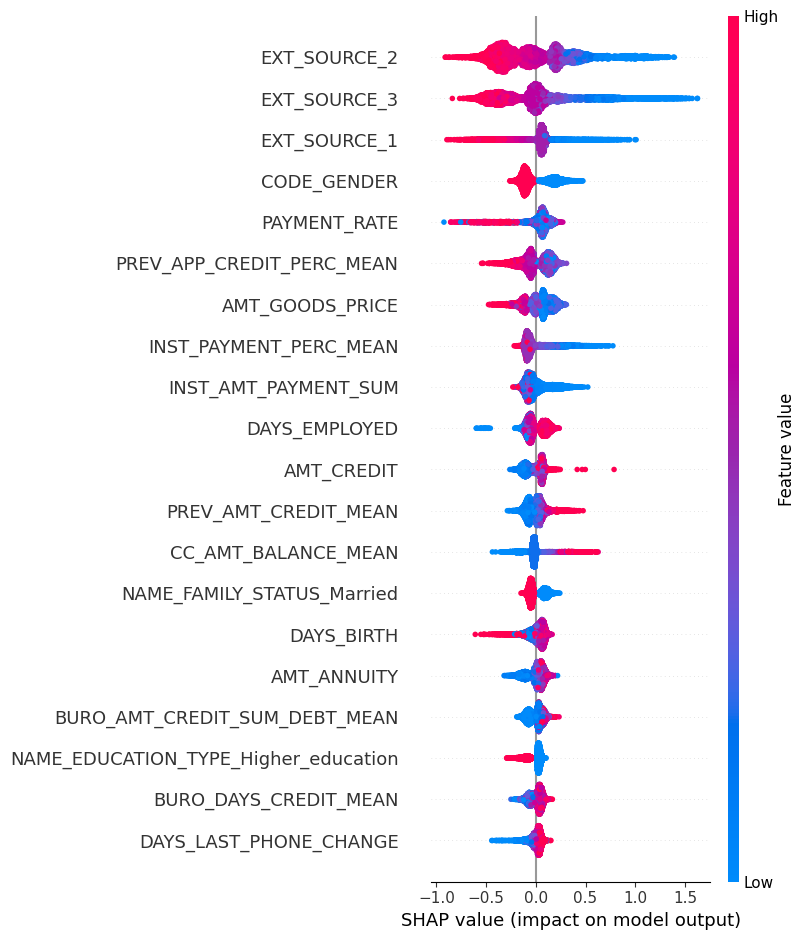

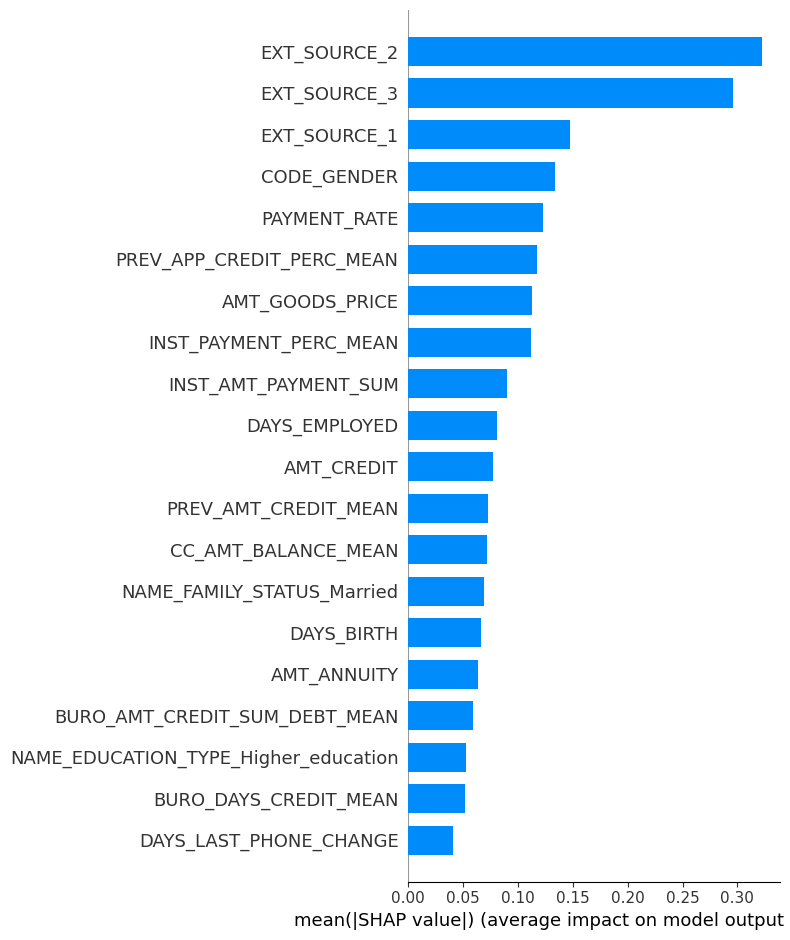

                       feature  importance
31                EXT_SOURCE_2    0.322771
32                EXT_SOURCE_3    0.295657
30                EXT_SOURCE_1    0.147486
0                  CODE_GENDER    0.133906
110               PAYMENT_RATE    0.122881
266  PREV_APP_CREDIT_PERC_MEAN    0.117511
7              AMT_GOODS_PRICE    0.112397
267     INST_PAYMENT_PERC_MEAN    0.111902
268       INST_AMT_PAYMENT_SUM    0.089603
10               DAYS_EMPLOYED    0.080849


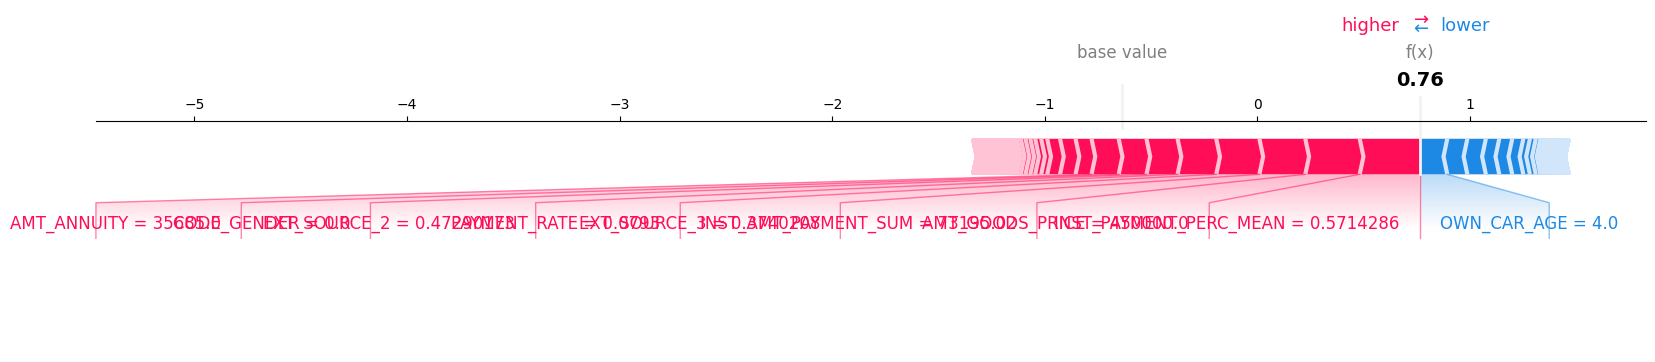

Index sélectionné : 5651


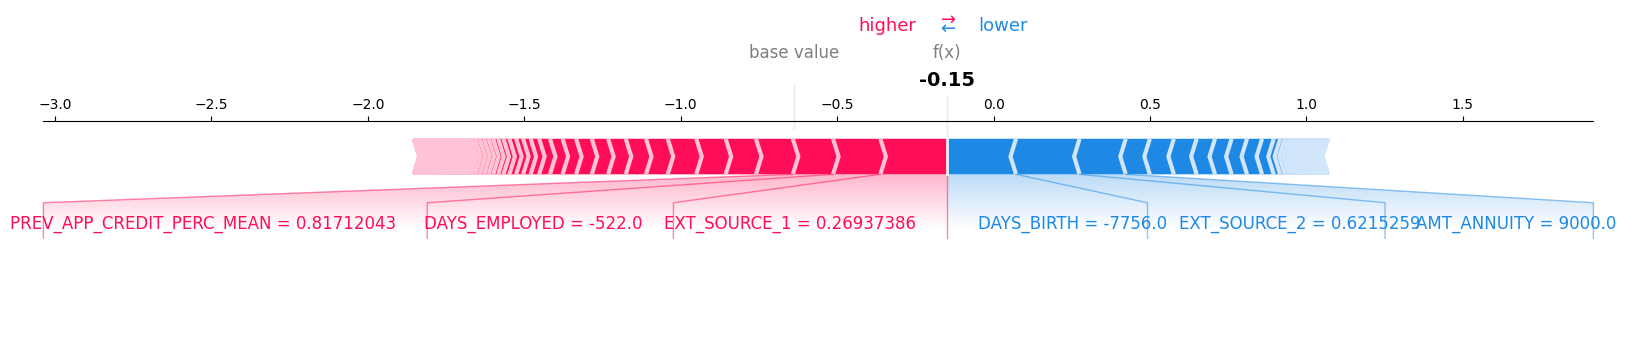

In [9]:
# calcul des shap values
import shap
import numpy as np

# Echantillon pour accélérer
X_sample = X_val.sample(10000, random_state=42) if len(X_val) > 1000 else X_val

# TreeExplainer
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample) #graphe lineaire
shap.summary_plot(shap_values, X_sample, plot_type="bar") #graphe en barplot

feature_importance = np.abs(shap_values).mean(axis=0) #classement features

importance_df = pd.DataFrame({"feature": X_sample.columns,"importance": feature_importance}).sort_values("importance", ascending=False) #creation dataframe

print(importance_df.head(10)) #affichage 10 premieres features

# exemple 1 echantillon num = 0
shap.force_plot(explainer.expected_value,shap_values[0,:],X_sample.iloc[0,:],matplotlib=True)

# choisir un index aléatoire
random_idx = random.randint(0, len(X_sample) - 1)

print("Index sélectionné :", random_idx)
shap.force_plot(explainer.expected_value,shap_values[random_idx,:],
    X_sample.iloc[random_idx,:],matplotlib=True)




